# Benchmarks
---

## 1 Hubble-Lemaître model (constant velocity gradient)
--- 

In [95]:
import matplotlib.pyplot as plt
import numpy             as np

from tqdm                 import tqdm
from astropy              import units, constants

from p3droslo.utils       import convert_angular_to_spatial
from p3droslo.plot        import plot_cube_2D
from p3droslo.object      import AstroObject
from p3droslo.observation import DataCube

from p3droslo.model       import TensorModel, SphericallySymmetric
from p3droslo.utils       import print_var, interpolate, planck
from p3droslo.lines       import Line
from p3droslo.loss        import Loss, fourier_loss_1D, fourier_loss_1D
from p3droslo.haar        import Haar

In [98]:
R = 495000.0
N = 128

nH2 = 1.0e+12        # [m^-3]
nCO = 1.0e-4 * nH2   # [m^-3]
T   = 45             # [k]
trb = 150.0          # [m/s]
cΔβ = 0.15

model = TensorModel(shape=(N,), sizes=(R,))
model['nCO'        ]  = nCO * np.ones(N)
model['temperature']  = T   * np.ones(N)
model['velocity_z']   = cΔβ * np.linspace(0.0, R, N)
model['v_turbulence'] = trb * np.ones(N)

In [99]:
65000/R

0.13131313131313133

In [100]:
R * cΔβ

74250.0

In [101]:
# Magritte setup
model_file = "magritte_model.hdf5"
lamda_file = "data/test.txt"

In [102]:
import torch
import torch.nn as nn

from torch.optim import Adam

# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [103]:
line = Line(
    species_name = "test",
    transition   = 0,
    datafile     = "data/test.txt",
    molar_mass   = 1.0
)

You have selected line:
    test(J=-)
Please check the properties that were inferred:
    Frequency         1.798754700e+11  Hz
    Einstein A coeff  1.000000000e-04  1/s
    Molar mass        1.0              g/mol


In [104]:
from astropy import constants

CC  = constants.c  .si.value   # Speed of light       [m/s]

def get_doppler_shifted_frequencies(v_los, frequencies):
    """
    Doppler shifts frequencies given the velocity along the line of sight.
    """
    # Compute the Doppler shift for each cell
    shift = 1.0 + v_los * (1.0 / CC)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, frequencies)
    
    return freqs

In [105]:
from time import time

def forward(model, freqs):
    """
    Forward model: image the given TensorModel at the given frequencies.
    """
    t =- time()
    nCO    = model['nCO']        
    tmp    = model['temperature']
    vel    = model['velocity_z']
    v_turb = model['v_turbulence']
    t += time()
    print("init       ", t)

    t =- time()
    frequencies = get_doppler_shifted_frequencies(vel, freqs)
    t += time()
    print("Doppler    ", t)
    
    # Compute the LTE line emissivity and opacity, and the line profile
    t =- time()
    eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)
    t += time()
    print("eta, chi    ", t)
    
    # Create an image of the line
    t =- time()
    img = model.create_image(eta, chi, axis=0)
    t += time()
    print("create image", t)
    
    return img

In [106]:
N_freqs = 100
v_pixel = 5000.0

dd    = (N_freqs-1)/2 * v_pixel/constants.c.si.value
fmin  = line.frequency - line.frequency*dd
fmax  = line.frequency + line.frequency*dd
freqs = torch.linspace(fmin, fmax, N_freqs, dtype=torch.float64)

In [107]:
with torch.no_grad():
    img = forward(model, freqs)

init        2.765655517578125e-05
Doppler     0.0013310909271240234
eta, chi     0.0032553672790527344
create image 0.0005817413330078125


In [108]:
from scipy.special import erf

# line width
δν = line.gaussian_width(model['temperature'], model['v_turbulence'])[0].item()

# Compute the prefactor
factor = constants.h.si.value * line.frequency / (4.0 * np.pi)

# Compute the LTE level populations
pop = line.LTE_pops(model['temperature'])

# Compute the emissivity and opacity
eta  = factor *  line.Einstein_A  * pop[line.upper]
chi  = factor * (line.Einstein_Ba * pop[line.lower] - line.Einstein_Bs * pop[line.upper])
eta *= model['nCO']
chi *= model['nCO']
eta  = eta[0].item()
chi  = chi[0].item()

Sij = eta / chi

In [109]:
abs_rel_diff = lambda a,b: np.abs(2.0*(a-b)/(a+b))

abs_rel_diff(eta/chi, planck(T, line.frequency))


2.932651092018961e-08

The optical depth is given by,
\begin{equation}
\begin{split}
\tau(\nu)
\ &= \
\int_{0}^{\ell} \text{d} l \ \chi_{ij} \, \phi\left( (1+\Delta\beta l) \nu \right) \\
\ &= \
\frac{\chi_{ij}}{2 \nu \Delta \beta}
\left(
    \text{Erf}\left[ \frac{\left(1 + \Delta\beta \ell \right) \nu - \nu_{ij}}{\delta\nu_{ij}} \right]
    \ - \
    \text{Erf}\left[ \frac{\nu - \nu_{ij}}{\delta\nu_{ij}} \right]
\right) .
\end{split}
\end{equation}
Hence, the resulting intensity reads,
\begin{equation}
I(\nu) \ = \ S_{ij} \left( 1 \ - \ e^{-\tau(\nu)} \right)
\end{equation}

In [110]:
# Analytic solution
ν = freqs.numpy()
fac = 1.0 + model['velocity_z'][-1].item() / constants.c.si.value
τ = constants.c.si.value * chi/(2.0*ν*cΔβ) * (erf((fac*ν-line.frequency)/δν) - erf((ν-line.frequency)/δν) )
I = Sij*(1.0 - np.exp(-τ))

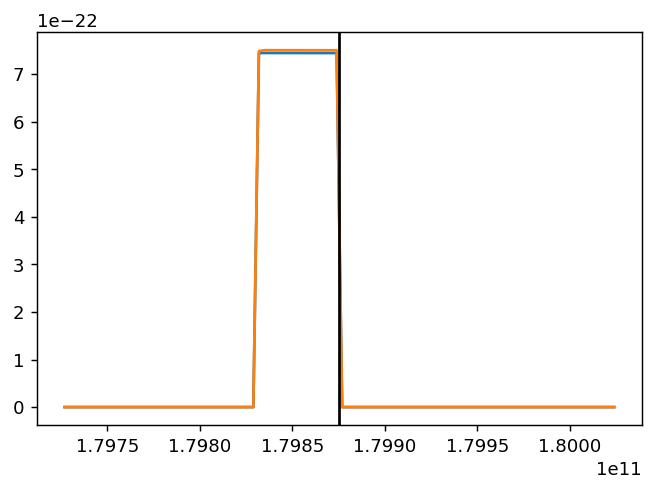

In [111]:
plt.figure(dpi=130)
plt.plot(ν, img.data)
plt.plot(ν, I)
plt.axvline(line.frequency, c='k')

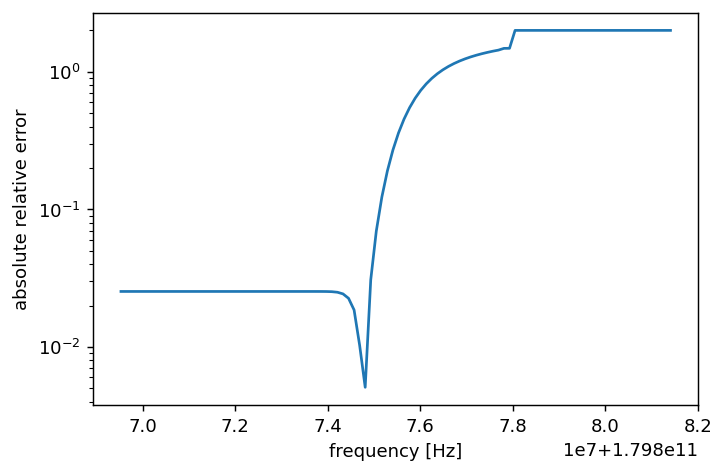

In [40]:
plt.figure(dpi=130)
plt.plot(ν, abs_rel_diff(img.data, I))
plt.xlabel('frequency [Hz]')
plt.ylabel('absolute relative error')
plt.yscale('log')